# Hybrid quantum-classical Neural Networks with PyTorch and Qiskit

## 3. Let's code! <a id='code'></a>


### 3.1 Imports <a id='imports'></a>
First, we import some handy packages that we will need, including Qiskit and PyTorch.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit.visualization import *

In [2]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from joblib import Parallel,delayed
from sklearn import tree
from sklearn.base import clone 
from sklearn.linear_model import ElasticNet

In [3]:
import array
import numpy as np
import warnings
import scipy.sparse as sp
import itertools
import pandas

from sklearn.base import BaseEstimator, ClassifierMixin, clone, is_classifier
from sklearn.base import MultiOutputMixin
from sklearn.base import MetaEstimatorMixin, is_regressor
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.utils import check_random_state
from sklearn.utils.deprecation import deprecated
from sklearn.utils.validation import _num_samples
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.validation import check_X_y, check_array
from sklearn.utils.validation import _deprecate_positional_args
from sklearn.utils.multiclass import (_check_partial_fit_first_call,
                               check_classification_targets,
                               _ovr_decision_function)
from sklearn.utils.metaestimators import _safe_split, available_if
from sklearn.exceptions import NotFittedError

from joblib import Parallel

import copy

In [4]:
# Import Qiskit

from qiskit import QuantumCircuit as qct
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator

from qiskit_aer.noise import NoiseModel
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import datetime

In [2]:
import sys
import os

# Add the src folder to the Python path
src_path = os.path.abspath(os.path.join(os.getcwd(), "..", "src"))
if src_path not in sys.path:
    sys.path.append(src_path)
    
import noise_model_modified # import noise model leveraging csv files or quantum database generated before

In [11]:
# Qiskit Runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator

In [8]:
print(qiskit.__version__)

1.1.1


In [6]:
import os, fnmatch
def find(pattern, path):
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result = os.path.join(root, name)
    return result

In [7]:
path = '/your_path_to/data/QuantumDatabase_v6'

backendName = '*sherbrooke*' # it can be *kyoto*, *osaka*, or *brisbane*
noise_model = noise_model_modified.NoiseModel.from_backend(
    gate_error=True,
    readout_error=True,
    thermal_relaxation=True,
    temperature=0,
    gate_lengths=True,
    gate_length_units="ns",
    warnings=None,
    path = path,
    ibmname = backendName
)

/users/otgo_so/Quantum-Digital-Twins/QDB_Python/noise_model_modified.py:359: UserWarning: When a BackendV2 is supplied, `warnings` are ignored, and their default values are used.
  warn(


In [14]:
#reading a coupling map from a csv file

pattern = backendName+'coupling_map.csv'
filename = find(pattern, path)
coupling_map = pandas.read_csv(filename, header = None)

coupling_m = []
for i in coupling_map.values.tolist()[0]:
    first = int(i.split('[')[1].split(']')[0].split(',')[0])
    second = int(i.split('[')[1].split(']')[0].split(',')[1])
    arr = [first, second]
    coupling_m.append(arr)
    
coupling_map = coupling_m   

In [15]:
#reading basis gates from a csv file

pattern = backendName + 'basis_gates.csv'
filename = find(pattern, path)
BasisgatesPD = pandas.read_csv(filename, header=None)
basis_gates = BasisgatesPD.values.tolist()[0]

In [8]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        thetas = [thetas]
        passmanager = generate_preset_pass_manager(optimization_level=3, backend=self.backend)
        job = passmanager.run(self._circuit)
        result = self.backend.run(job, 
              shots = self.shots,
              parameter_binds = [{self.theta: theta} for theta in thetas]).result()#parameter_binds = [{self.theta: thetas}]
        
        result = result.get_counts(0)
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)

        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

Let's test the implementation

In [24]:
simulator = AerSimulator(method = "matrix_product_state",
                         #device="GPU", #if you have access to GPUs
                         noise_model=noise_model)

circ = QuantumCircuit(1, simulator, 100)
print('Expected value for rotation pi {}'.format(circ.run([np.pi])[0]))
circ._circuit.draw()

Expected value for rotation pi 0.57


┌───┐ ░ ┌───────────┐ ░ ┌─┐
     q: ┤ H ├─░─┤ Ry(theta) ├─░─┤M├
        └───┘ ░ └───────────┘ ░ └╥┘
meas: 1/═════════════════════════╩═
                                 0

### 3.3 Create a "Quantum-Classical Class" with PyTorch <a id='qc-class'></a>
Now that our quantum circuit is defined, we can create the functions needed for backpropagation using PyTorch. [The forward and backward passes](http://www.ai.mit.edu/courses/6.034b/backprops.pdf) contain elements from our Qiskit class. The backward pass directly computes the analytical gradients using the finite difference formula we introduced above.

In [9]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

### 3.4 Data Loading and Preprocessing <a id='data-loading-preprocessing'></a>
##### Putting this all together:
We will create a simple hybrid neural network to classify images of two types of digits (0 or 1) from the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). We first load MNIST and filter for pictures containing 0's and 1's. These will serve as inputs for our neural network to classify.

#### Training data

In [10]:
# Concentrating on the first 100 samples
n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 3 and 5
idx=np.array([np.where(X_train.targets == 3)[0][:n_samples],
                np.where(X_train.targets == 5)[0][:n_samples]]).flatten()
'''
idx=np.array([np.where(X_train.targets == 0)[0][:n_samples],
                np.where(X_train.targets == 1)[0][:n_samples]]).flatten()

'''
# Leaving only labels 0 and 1 
#idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
#                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

for i,j in enumerate(X_train.targets):
    if j==3:
        X_train.targets[i] = 0 
    else: 
        X_train.targets[i]= 1 

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

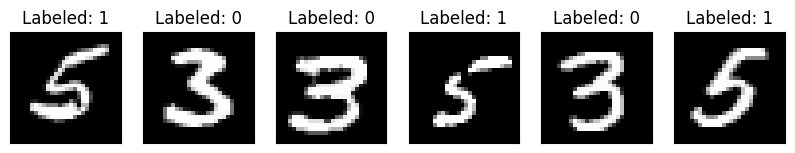

In [11]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

# Testing data

In [12]:
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))


'''
idx=np.array([np.where(X_test.targets == 0)[0][:n_samples],
                np.where(X_test.targets == 1)[0][:n_samples]]).flatten()

'''

# Leaving only labels 3 and 5
idx=np.array([np.where(X_test.targets == 3)[0][:n_samples],
                np.where(X_test.targets == 5)[0][:n_samples]]).flatten()


X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

for i,j in enumerate(X_test.targets):
    if j==3:
        X_test.targets[i] = 0 
    else: 
        X_test.targets[i]= 1 

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

So far, we have loaded the data and coded a class that creates our quantum circuit which contains 1 trainable parameter. This quantum parameter will be inserted into a classical neural network along with the other classical parameters to form the hybrid neural network. We also created backward and forward pass functions that allow us to do backpropagation and optimise our neural network. Lastly, we need to specify our neural network architecture such that we can begin to train our parameters using optimisation techniques provided by PyTorch. 


### 3.5 Creating the Hybrid Neural Network <a id='hybrid-nn'></a>
We can use a neat PyTorch pipeline to create a neural network architecture. The network will need to be compatible in terms of its dimensionality when we insert the quantum layer (i.e. our quantum circuit). Since our quantum  in this example contains 1 parameter, we must ensure the network condenses neurons down to size 1. We create a typical Convolutional Neural Network with two fully-connected layers at the end. The value of the last neuron of the fully-connected layer is fed as the parameter $\theta$ into our quantum circuit. The circuit measurement then serves as the final prediction for 0 or 1 as provided by a $\sigma_z$ measurement.

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 1)
        #self.hybrid = Hybrid(AerSimulator(#method = "matrix_product_state", 
                                          #device = "GPU", 
                                          #noise_model=noise_model), 100, np.pi / 2)
        self.hybrid = Hybrid(AerSimulator(), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)


### 3.6 Training the Network <a id='training'></a>
We now have all the ingredients to train our hybrid network! We can specify any [PyTorch optimiser](https://pytorch.org/docs/stable/optim.html), [learning rate](https://en.wikipedia.org/wiki/Learning_rate) and [cost/loss function](https://en.wikipedia.org/wiki/Loss_function) in order to train over multiple epochs. In this instance, we use the [Adam optimiser](https://arxiv.org/abs/1412.6980), a learning rate of 0.001 and the [negative log-likelihood loss function](https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html).

In [18]:
for batch_idx, (data, target) in enumerate(train_loader):
    print(data.shape)

torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
t

In [15]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 10
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    #i=0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        total_loss.append(loss.item()) 
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1])) 

/tmp/ipykernel_1439913/2571825612.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  result = torch.tensor([expectation_z])


Training [10%]	Loss: -0.4955
Training [20%]	Loss: -0.6922
Training [30%]	Loss: -0.8511
Training [40%]	Loss: -0.8723
Training [50%]	Loss: -0.9022
Training [60%]	Loss: -0.9198
Training [70%]	Loss: -0.9182
Training [80%]	Loss: -0.9286
Training [90%]	Loss: -0.9479
Training [100%]	Loss: -0.9431


Plot the training graph

Text(0, 0.5, 'Neg Log Likelihood Loss')

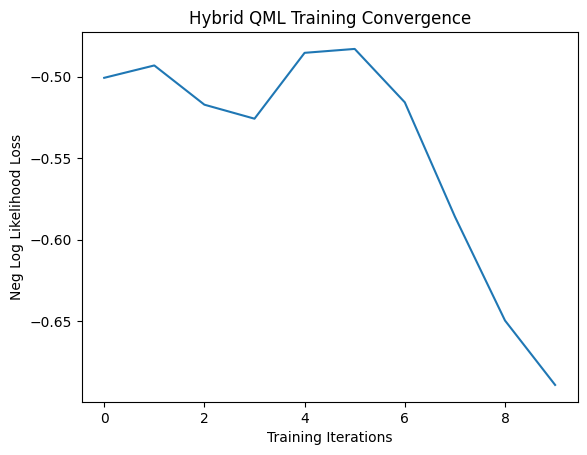

In [36]:
#noisy kyoto: 3-5
plt.plot(loss_list)
plt.title('Hybrid QML Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

Text(0, 0.5, 'Neg Log Likelihood Loss')

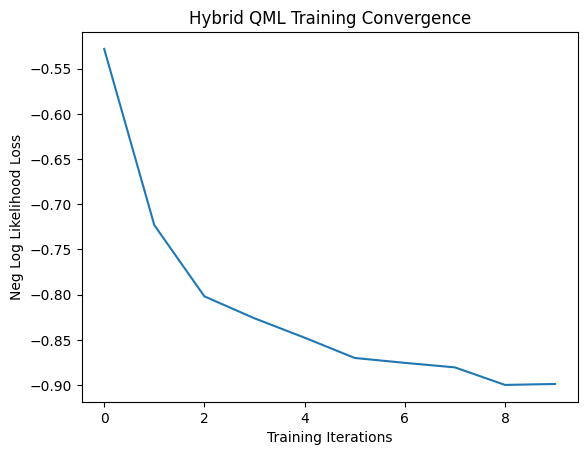

In [29]:
#noisy osaka: 3-5
plt.plot(loss_list)
plt.title('Hybrid QML Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

Text(0, 0.5, 'Neg Log Likelihood Loss')

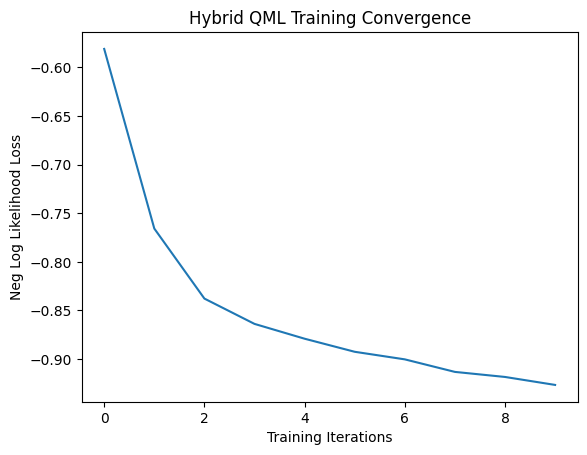

In [42]:
#noisy brisbane: 3-5
plt.plot(loss_list)
plt.title('Hybrid QML Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

Text(0, 0.5, 'Neg Log Likelihood Loss')

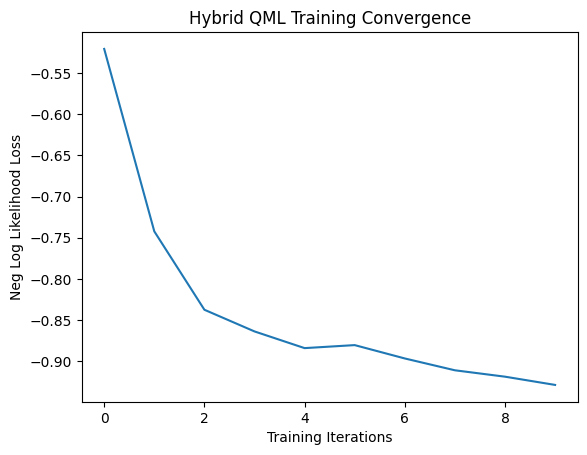

In [24]:
#noisy sherbrooke: 3-5
plt.plot(loss_list)
plt.title('Hybrid QML Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

Text(0, 0.5, 'Neg Log Likelihood Loss')

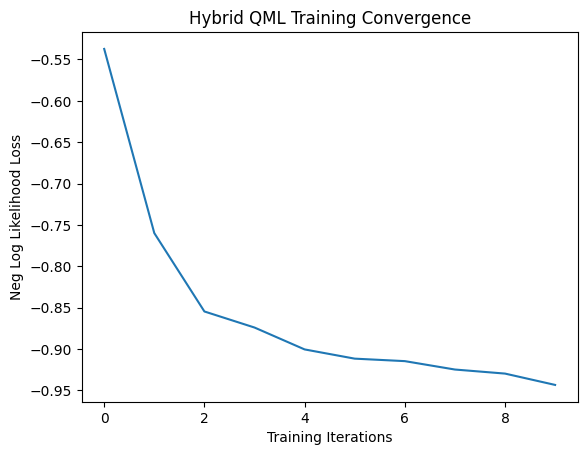

In [49]:
#noisy emulator: 3-5
plt.plot(loss_list)
plt.title('Hybrid QML Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

Text(0, 0.5, 'Neg Log Likelihood Loss')

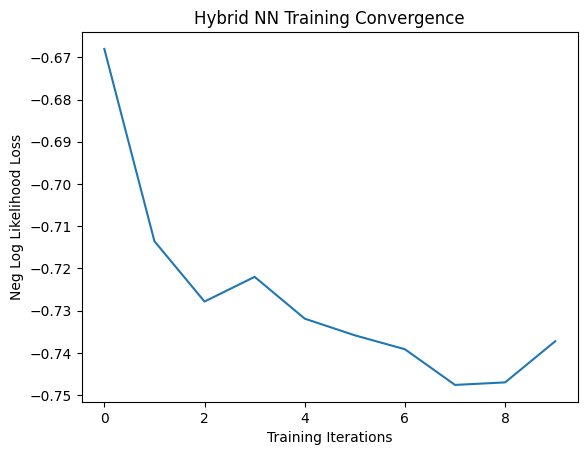

In [53]:
#noisy kyoto
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

Text(0, 0.5, 'Neg Log Likelihood Loss')

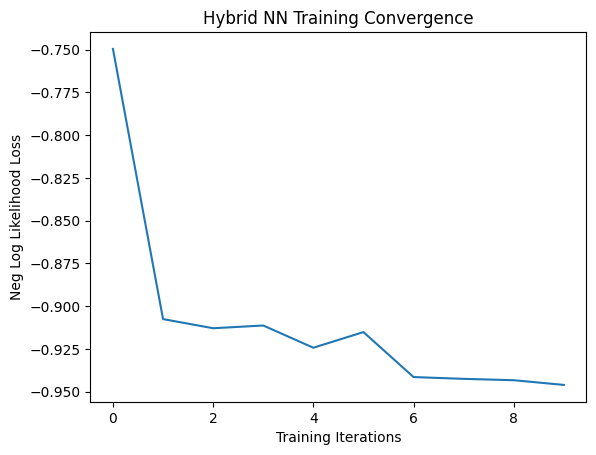

In [69]:
#noisy brisbane
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

Text(0, 0.5, 'Neg Log Likelihood Loss')

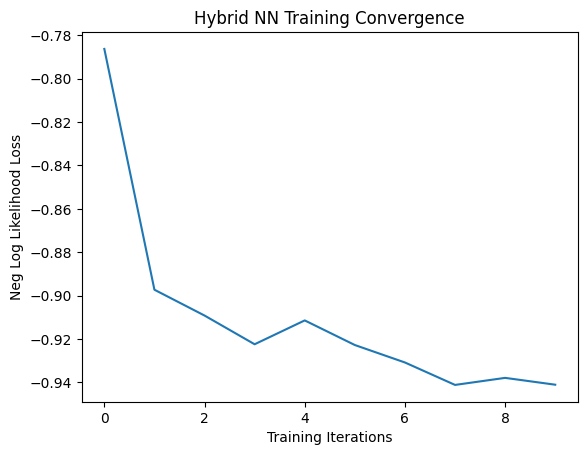

In [66]:
#noisy osaka
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

Text(0, 0.5, 'Neg Log Likelihood Loss')

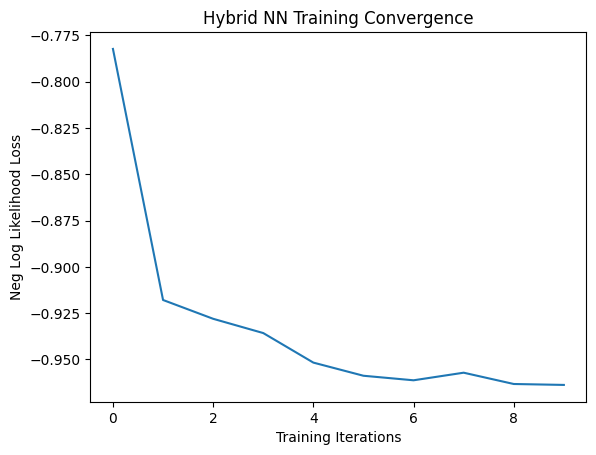

In [19]:
#noisy sherbrooke
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

Plot the training graph

Text(0, 0.5, 'Neg Log Likelihood Loss')

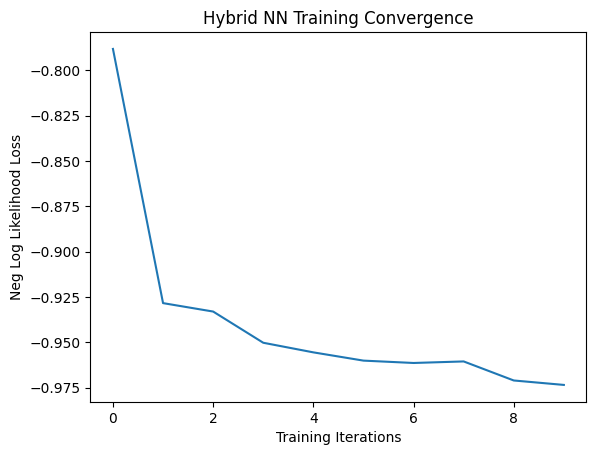

In [48]:
#ideal QC
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

### 3.7 Testing the Network <a id='testing'></a>

In [37]:
#ibm kyoto: 3-5
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )
#print("?:", total_loss)    

Performance on test data:
	Loss: -0.7052
	Accuracy: 96.0%


In [30]:
#ibm osaka: 3-5
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )
#print("?:", total_loss)    

Performance on test data:
	Loss: -0.8867
	Accuracy: 97.0%


In [43]:
#ibm brisbane: 3-5
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )
#print("?:", total_loss)    

Performance on test data:
	Loss: -0.9164
	Accuracy: 94.0%


In [43]:
#ibm sherbrooke: 3-5
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )
#print("?:", total_loss)    

Performance on test data:
	Loss: -0.9164
	Accuracy: 94.0%


In [50]:
#ibm emulator: 3-5
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )
#print("?:", total_loss)    

Performance on test data:
	Loss: -0.9328
	Accuracy: 96.0%


In [33]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )
#print("?:", total_loss)    

Performance on test data:
	Loss: -0.8343
	Accuracy: 100.0%


In [54]:
#ibm kyoto
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )
#print("?:", total_loss)    

Performance on test data:
	Loss: -0.7385
	Accuracy: 100.0%


In [70]:
#ibm brisbane
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )
#print("?:", total_loss)    

Performance on test data:
	Loss: -0.9435
	Accuracy: 100.0%


In [67]:
#ibm osaka
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )
#print("?:", total_loss)    

Performance on test data:
	Loss: -0.9383
	Accuracy: 100.0%


In [20]:
#ibm sherbrooke
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )
#print("?:", total_loss)    

Performance on test data:
	Loss: -0.9514
	Accuracy: 100.0%


In [49]:
score=[]
targets=[]

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):

        output = model(data)

        pred = output.argmax(dim=1, keepdim=True) 
        score.append(pred.item())
        targets.append(target.item())


score = np.array(score)
targets = np.array(targets)

from sklearn.metrics import accuracy_score

print('Accuracy for test data: \t', (accuracy_score(score,targets)))

Accuracy for test data: 	 1.0


In [55]:
#ibm kyoto
score=[]
targets=[]

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):

        output = model(data)

        pred = output.argmax(dim=1, keepdim=True) 
        score.append(pred.item())
        targets.append(target.item())


score = np.array(score)
targets = np.array(targets)

from sklearn.metrics import accuracy_score

print('Accuracy for test data: \t', (accuracy_score(score,targets)))

Accuracy for test data: 	 1.0


In [38]:
#ibm kyoto: 3-5
score=[]
targets=[]

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):

        output = model(data)

        pred = output.argmax(dim=1, keepdim=True) 
        score.append(pred.item())
        targets.append(target.item())


score = np.array(score)
targets = np.array(targets)

from sklearn.metrics import accuracy_score

print('Accuracy for test data: \t', (accuracy_score(score,targets)))

Accuracy for test data: 	 0.97


In [71]:
#ibm brisbane
score=[]
targets=[]

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):

        output = model(data)

        pred = output.argmax(dim=1, keepdim=True) 
        score.append(pred.item())
        targets.append(target.item())


score = np.array(score)
targets = np.array(targets)

from sklearn.metrics import accuracy_score

print('Accuracy for test data: \t', (accuracy_score(score,targets)))

Accuracy for test data: 	 1.0


In [68]:
#ibm osaka
score=[]
targets=[]

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):

        output = model(data)

        pred = output.argmax(dim=1, keepdim=True) 
        score.append(pred.item())
        targets.append(target.item())


score = np.array(score)
targets = np.array(targets)

from sklearn.metrics import accuracy_score

print('Accuracy for test data: \t', (accuracy_score(score,targets)))

Accuracy for test data: 	 1.0


In [21]:
#ibm sherbrooke
score=[]
targets=[]

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):

        output = model(data)

        pred = output.argmax(dim=1, keepdim=True) 
        score.append(pred.item())
        targets.append(target.item())


score = np.array(score)
targets = np.array(targets)

from sklearn.metrics import accuracy_score

print('Accuracy for test data: \t', (accuracy_score(score,targets)))

Accuracy for test data: 	 1.0


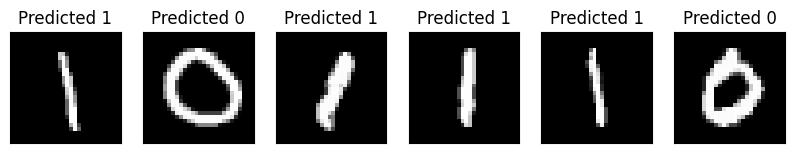

In [51]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    score=[]
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        
        #print(target.item(), pred.item())

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        score.append(pred.item())
        count += 1
        
score = np.array(score).reshape(6,1)

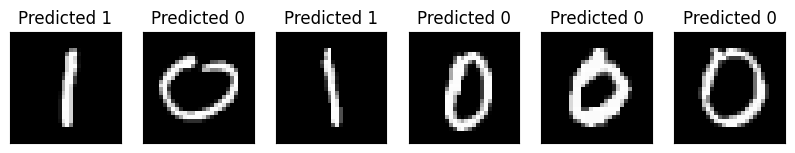

In [56]:
#ibm kyoto
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    score=[]
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        
        #print(target.item(), pred.item())

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        score.append(pred.item())
        count += 1
        
score = np.array(score).reshape(6,1)

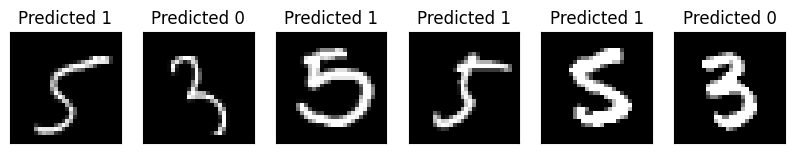

In [39]:
#ibm kyoto: 3-5
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    score=[]
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        
        #print(target.item(), pred.item())

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        score.append(pred.item())
        count += 1
        
score = np.array(score).reshape(6,1)

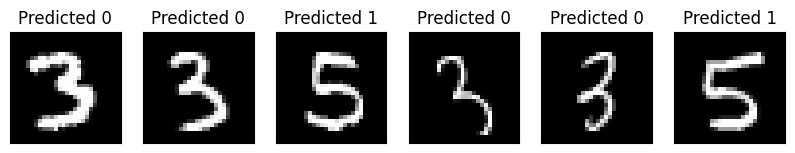

In [31]:
#ibm osaka: 3-5
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    score=[]
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        
        #print(target.item(), pred.item())

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        score.append(pred.item())
        count += 1
        
score = np.array(score).reshape(6,1)

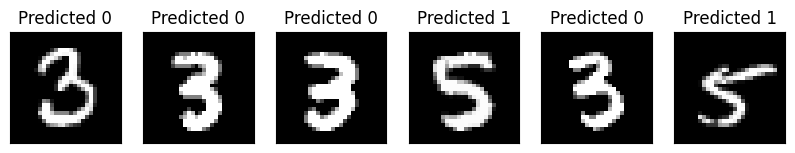

In [44]:
#ibm brisbane: 3-5
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    score=[]
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        
        #print(target.item(), pred.item())

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        score.append(pred.item())
        count += 1
        
score = np.array(score).reshape(6,1)

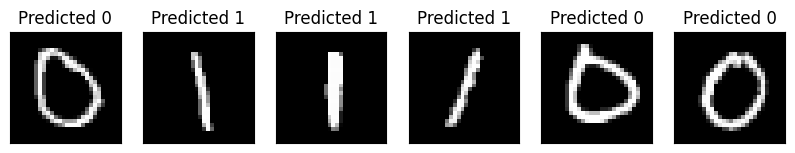

In [72]:
#ibm brisbane
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    score=[]
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        
        #print(target.item(), pred.item())

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        score.append(pred.item())
        count += 1
        
score = np.array(score).reshape(6,1)

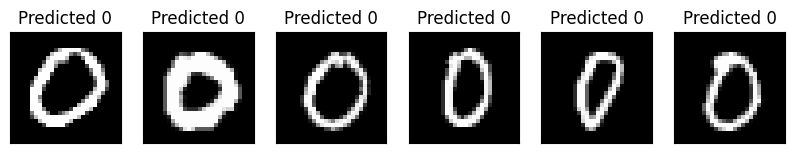

In [69]:
#ibm osaka
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    score=[]
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        
        #print(target.item(), pred.item())

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        score.append(pred.item())
        count += 1
        
score = np.array(score).reshape(6,1)

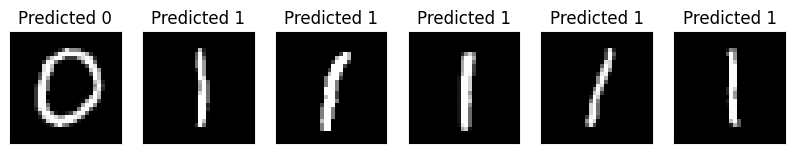

In [22]:
#ibm sherbrooke
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    score=[]
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        
        #print(target.item(), pred.item())

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        score.append(pred.item())
        count += 1
        
score = np.array(score).reshape(6,1)

In [56]:
n_samples_show = 100
count = 0
#fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    score=[]
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        
        #print(target.item(),pred.shape)

        score.append(pred.item())
        count += 1
        
score = np.array(score).reshape(100,1)

In [57]:
#ibm kyoto
n_samples_show = 100
count = 0
#fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    score=[]
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        
        #print(target.item(),pred.shape)

        score.append(pred.item())
        count += 1
        
score = np.array(score).reshape(100,1)

In [73]:
#ibm brisbane
n_samples_show = 100
count = 0
#fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    score=[]
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        
        #print(target.item(),pred.shape)

        score.append(pred.item())
        count += 1
        
score = np.array(score).reshape(100,1)

In [70]:
#ibm osaka
n_samples_show = 100
count = 0
#fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    score=[]
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        
        #print(target.item(),pred.shape)

        score.append(pred.item())
        count += 1
        
score = np.array(score).reshape(100,1)

In [53]:
model.eval()
with torch.no_grad():
    score=[]
    targt=[]
    for batch_idx, (data, target) in enumerate(test_loader):
        
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        score.append(pred.item())
        targt.append(target.item())
        
score = np.array(score).reshape(X_test.targets.shape[0],1)
targt = np.array(targt).reshape(X_test.targets.shape[0],1)

In [58]:
#ibm kyoto
model.eval()
with torch.no_grad():
    score=[]
    targt=[]
    for batch_idx, (data, target) in enumerate(test_loader):
        
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        score.append(pred.item())
        targt.append(target.item())
        
score = np.array(score).reshape(X_test.targets.shape[0],1)
targt = np.array(targt).reshape(X_test.targets.shape[0],1)

In [74]:
#ibm brisbane
model.eval()
with torch.no_grad():
    score=[]
    targt=[]
    for batch_idx, (data, target) in enumerate(test_loader):
        
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        score.append(pred.item())
        targt.append(target.item())
        
score = np.array(score).reshape(X_test.targets.shape[0],1)
targt = np.array(targt).reshape(X_test.targets.shape[0],1)

In [71]:
#ibm osaka
model.eval()
with torch.no_grad():
    score=[]
    targt=[]
    for batch_idx, (data, target) in enumerate(test_loader):
        
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        score.append(pred.item())
        targt.append(target.item())
        
score = np.array(score).reshape(X_test.targets.shape[0],1)
targt = np.array(targt).reshape(X_test.targets.shape[0],1)

In [54]:
score.shape,targt.shape

((100, 1), (100, 1))